<a href="https://colab.research.google.com/github/JuneshG/Thesis/blob/main/Final_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Statistical Analysis

In [1]:
# A0. MOUNT DRIVE (in Colab)
from google.colab import drive
drive.mount('/content/drive')
from scipy.ndimage import sobel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# A1. LOAD TRAIN IMAGES (60k samples)
train_img_path = '/content/drive/MyDrive/Thesis_3/data/mnist_img_train.txt'
X_train_full = np.loadtxt(train_img_path)  # shape: (60000, 784)
print("Train image data shape:", X_train_full.shape)

# A2. LOAD TRAIN STRAIN ENERGY
train_psi_path = '/content/drive/MyDrive/Thesis_3/data/summary_psi_train_all.txt'
train_psi = np.loadtxt(train_psi_path)  # shape: (60000, <num_cols>)
# Suppose final-step strain energy is column 12:
y_train_full = train_psi[:, 12]
print("Train strain shape:", y_train_full.shape)

# A3. LOAD TEST IMAGES (10k samples)
test_img_path = '/content/drive/MyDrive/Thesis_3/data/mnist_img_test.txt'
X_test = np.loadtxt(test_img_path)  # shape: (10000, 784)
print("Test image data shape:", X_test.shape)

# A4. LOAD TEST STRAIN ENERGY
test_psi_path = '/content/drive/MyDrive/Thesis_3/data/summary_psi_test_all.txt'
test_psi = np.loadtxt(test_psi_path)  # shape: (10000, <num_cols>)
y_test = test_psi[:, 12]
print("Test strain shape:", y_test.shape)


Train image data shape: (60000, 784)
Train strain shape: (60000,)
Test image data shape: (10000, 784)
Test strain shape: (10000,)


In [3]:
from sklearn.model_selection import train_test_split
#Let's say we want 10,000 samples for validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size = 10000,   #10,000 samples for validation
    random_state = 42
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train:", y_train.shape, "y_val:", y_val.shape)

X_train: (50000, 784) X_val: (10000, 784)
y_train: (50000,) y_val: (10000,)


###Extract Features




In [4]:
image_data_path = '/content/drive/MyDrive/Thesis_3/data/mnist_img_train.txt'
image_data = np.loadtxt(image_data_path)
print(image_data.shape)

#initialize features
average_intensity = []
contrast = []
edge_features = []

#compute features for each image
for image_row in image_data:
    #image reshape
    image = image_row.reshape(28, 28)

    # Average intensity
    avg_intensity = np.mean(image)
    average_intensity.append(avg_intensity)

    #contrast (standard deviation)
    std_dev = np.std(image)
    contrast.append(std_dev)

    # Edge features (sum of Sobel filter output)
    edges = np.hypot(sobel(image, axis=0), sobel(image, axis=1))
    edge_features.append(np.sum(edges))

# Convert to NumPy arrays
average_intensity = np.array(average_intensity)
contrast = np.array(contrast)
edge_features = np.array(edge_features)

(60000, 784)


###Load Strain Energy and Combine Data


In [7]:
# Load strain energy data
strain_energy_data_path = '/content/drive/MyDrive/Thesis_3/data/summary_psi_train_all.txt'  # Update with your file path
strain_energy_data = np.loadtxt(strain_energy_data_path)
final_step_energy = strain_energy_data[:, 12]  # Extract column 12 for final step energy

features_df = pd.DataFrame({
    'Average Intensity': average_intensity,
    'Contrast': contrast,
    'Edge Features': edge_features,
    'Strain Energy': final_step_energy
})
print(features_df.head())


   Average Intensity   Contrast  Edge Features  Strain Energy
0          35.108418  79.648829  160439.668496     153.468572
1          39.661990  83.887159  173982.582895     171.283544
2          24.799745  65.579749  136883.479447     156.544758
3          21.855867  66.078887   96648.585758     142.332764
4          29.609694  74.371315  141647.658441     170.884384


###Correlation Analysis

Correlation Matrix:
                   Average Intensity  Contrast  Edge Features  Strain Energy
Average Intensity           1.000000  0.982002       0.825654       0.767560
Contrast                    0.982002  1.000000       0.812221       0.751357
Edge Features               0.825654  0.812221       1.000000       0.648687
Strain Energy               0.767560  0.751357       0.648687       1.000000


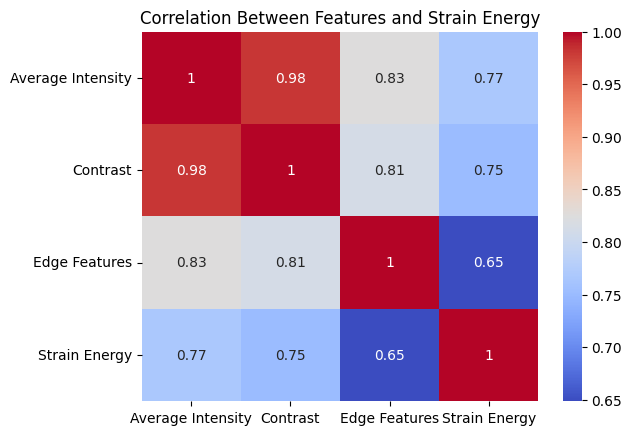

In [8]:
# Compute correlations
correlation_matrix = features_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Features and Strain Energy")
plt.show()


###Regression Analysis

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = lin_reg.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val  = r2_score(y_val, y_val_pred)
print("[Val] MSE:", mse_val, "R2:", r2_val)

# If you're satisfied with hyperparams, do final test:
y_test_pred = lin_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test  = r2_score(y_test, y_test_pred)
print("[Test] MSE:", mse_test, "R2:", r2_test)


[Val] MSE: 50.0200535058156 R2: 0.7898943208487084
[Test] MSE: 46.20856011405153 R2: 0.8026683203977889


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val  = r2_score(y_val, y_val_pred)
print("[Val] MSE:", mse_val, "R2:", r2_val)

# If you're satisfied with hyperparams, do final test:
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test  = r2_score(y_test, y_test_pred)
print("[Test] MSE:", mse_test, "R2:", r2_test)


[Val] MSE: 34.205324792958876 R2: 0.85632296464098
[Test] MSE: 34.627869093159156 R2: 0.852123166090157


In [19]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val  = r2_score(y_val, y_val_pred)
print("[Val] MSE:", mse_val, "R2:", r2_val)

# If you're satisfied with hyperparams, do final test:
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test  = r2_score(y_test, y_test_pred)
print("[Test] MSE:", mse_test, "R2:", r2_test)



[Val] MSE: 17.311329438408347 R2: 0.9272849912436488
[Test] MSE: 17.202590639024375 R2: 0.9265370724400545


##Deep Learning Integration

### CNN Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1) Reshape data for CNN input: (samples, 28, 28, 1)
# X_train_cnn, X_val_cnn, X_test_cnn already shaped appropriately, e.g.:

X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_val_cnn   = X_val.reshape(-1, 28, 28, 1)
X_test_cnn  = X_test.reshape(-1, 28, 28, 1)

# 2) Define an improved CNN
model = Sequential([
    Conv2D(128, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(1028, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    # Dropout(0.2),  # a small dropout
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # single output for strain energy
])

# Include both 'mae' and 'mse' as metrics for convenience
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='mse',
              metrics=['mae','mse'])

model.summary()

# 3) Train on train set, validate on val set
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=40,
    batch_size=32
)

# 4) Evaluate on test set
results = model.evaluate(X_test_cnn, y_test, verbose=1)
print("Test Loss (MSE):", results[0])  # because the 'loss' is MSE
print("Test MAE:", results[1])        # first metric is 'mae'
print("Test MSE:", results[2])        # second metric is 'mse'


NameError: name 'X_train' is not defined

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 11, 11, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1028)                │          66,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         526,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 878,213 (3.35 MB)

 Trainable params: 878,213 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 191s 118ms/step - loss: 557.7067 - mae: 10.8842 - val_loss: 104.8340 - val_mae: 8.7740
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 185s 108ms/step - loss: 40.6055 - mae: 4.9085 - val_loss: 40.5676 - val_mae: 5.1691
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 168s 108ms/step - loss: 33.2524 - mae: 4.4477 - val_loss: 26.8180 - val_mae: 3.9652
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 204s 109ms/step - loss: 30.4485 - mae: 4.2609 - val_loss: 24.0120 - val_mae: 3.7219
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - loss: 25.7882 - mae: 3.9125 - val_loss: 34.8657 - val_mae: 4.6488
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - loss: 22.6264 - mae: 3.6628 - val_loss: 19.1959 - val_mae: 3.2853
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 199s 104ms/step - loss: 21.6484 - mae: 3.5858 - val_loss: 31.6284 - val_mae: 4.3971
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 104ms/step - loss: 22.6878 - mae: 3.6538 - val_loss: 16.9922 - val_m

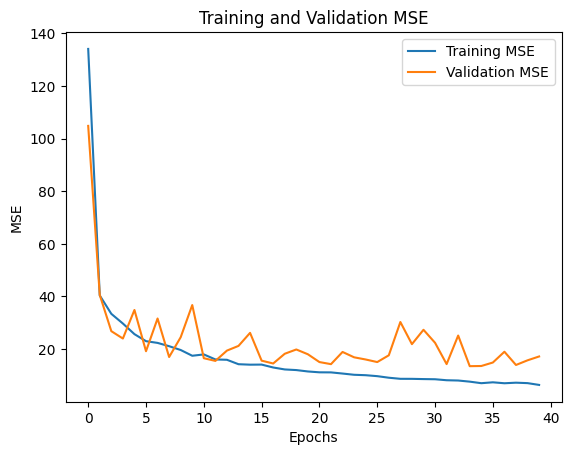

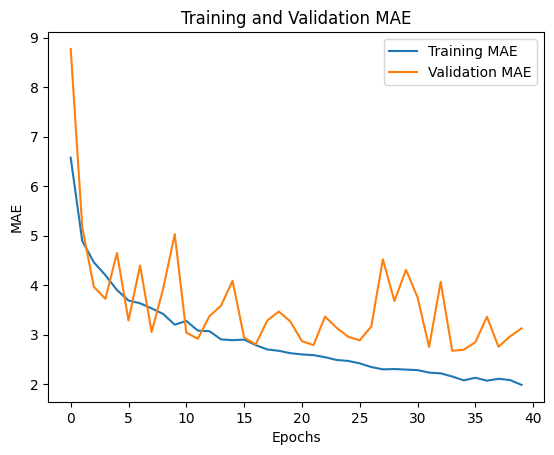

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

model = Sequential([
    Conv2D(128, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(1028, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    # Dropout(0.2),  # a small dropout
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # single output for strain energy
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

model.summary()

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=40,
    batch_size=32
)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_cnn, y_test, verbose=1)
print(f"Test MSE (loss): {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Plot the training & validation loss
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()

# Plot MAE as well if you like
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()


###Vision Transformer (ViT) in Keras
A Vision Transformer splits an image into patches, embeds each patch, then uses a Transformer encoder (multi-head self-attention + feedforward networks) to process those embeddings.

Below is a simplified example of a custom ViT in Keras for regression (predicting strain energy). If you prefer, you can also explore official libraries (e.g., Hugging Face Transformers) or other open-source implementations. For brevity, this code shows the essential components.

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --------
# 1) Hyperparameters
# --------
IMAGE_SIZE = 28  # Height and width of the input image
PATCH_SIZE = 4   # Patch size
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) * (IMAGE_SIZE // PATCH_SIZE)  # # of patches
EMBED_DIM = 64   # Dimensionality of patch embeddings
NUM_HEADS = 8    # Number of attention heads
NUM_LAYERS = 6   # Number of Transformer blocks
FF_DIM = 256     # Hidden layer size in feedforward network inside Transformer
MLP_UNITS = [256, 128]  # MLP units after Transformer for regression
BATCH_SIZE = 32
EPOCHS = 15  # Increase as needed
CHANNELS = 1  # Grayscale images
# --------


In [44]:

# 2) Utility Layers
# --------
class PatchExtract(layers.Layer):
    """Split image into patches of size PATCH_SIZE x PATCH_SIZE."""
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # [batch_size, num_patches_y, num_patches_x, patch_size*patch_size]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEmbedding(layers.Layer):
    """Map each patch to a learnable embedding."""
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(embed_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embed_dim
        )

    def call(self, patch_vectors):
        # [batch_size, num_patches, embed_dim]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        embedded = self.projection(patch_vectors)
        embedded = embedded + self.position_embedding(positions)
        return embedded

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training): # The 'training' argument is important
        # Self-attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training) # Pass 'training' to Dropout
        out1 = self.layernorm1(inputs + attn_output)
        # Feed forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training) # Pass 'training' to Dropout
        return self.layernorm2(out1 + ffn_output)

# --------



In [45]:
# 3) Build the ViT Model for Regression
# --------
def create_vit_regressor(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_dim=FF_DIM,
    mlp_units=MLP_UNITS,
    channels=CHANNELS
):
    inputs = layers.Input(shape=(image_size, image_size, channels))

    # Step 1: Extract patches
    patches = PatchExtract(patch_size)(inputs)

    # Step 2: Embed patches + position embeddings
    patch_embeddings = PatchEmbedding(NUM_PATCHES, embed_dim)(patches)

    # Step 3: Transformer blocks
    x = patch_embeddings
    for _ in range(num_layers):
        # Pass training=True to enable dropout during training
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)

    # Step 4: Global average pooling of patch embeddings
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Step 5: MLP head for regression
    for units in mlp_units:
        x = layers.Dense(units, activation='relu')(x)
    outputs = layers.Dense(1)(x)  # Single output for strain energy

    model = keras.Model(inputs=inputs, outputs=outputs, name="ViT_Regression")
    return model

In [46]:
# Example usage
vit_model = create_vit_regressor()
vit_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
vit_model.summary()

# --------

Model: "ViT_Regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_extract_4 (PatchExtract)       │ (None, None, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding_4 (PatchEmbedding)   │ (None, 49, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_16                 │ (None, 49, 64)              │         166,016 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_17                 │ (None, 49, 64)              │         166,016 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_18                 │ (None, 49, 64)              │         166,016 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_19                 │ (None, 49, 64)              │         166,016 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_20                 │ (None, 49, 64)              │         166,016 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_21                 │ (None, 49, 64)              │         166,016 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_48               │ (None, 49, 64)              │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,050,113 (4.01 MB)

 Trainable params: 1,050,113 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
#4) Training
# --------
#Reshape the input data to (samples, 28, 28, 1) for the ViT model:
X_train_vit = X_train.reshape(-1, 28, 28, 1)
X_val_vit   = X_val.reshape(-1, 28, 28, 1)


vit_model.fit(X_train_vit, y_train, # Pass the reshaped X_train_vit
              validation_data=(X_val_vit, y_val), # Pass the reshaped X_val_vit
              epochs=EPOCHS,
              batch_size=BATCH_SIZE)
history_vit = vit_model.history.history

# --------

NameError: name 'X_train' is not defined

In [42]:
# Plot the training & validation loss
plt.plot(history_vit.history['loss'], label='Training MSE')
plt.plot(history_vit.history['val_loss'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('ViT Training and Validation MSE')
plt.legend()
plt.show()

# Plot MAE as well if you like
plt.plot(history_vit.history['mae'], label='Training MAE')
plt.plot(history_vit.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('ViT Training and Validation MAE')
plt.legend()
plt.show()

AttributeError: 'dict' object has no attribute 'history'

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
IMAGE_SIZE = 28
PATCH_SIZE = 7     # Fewer patches (4x4 = 16 total)
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE)**2
EMBED_DIM = 32     # Smaller embedding dimension
NUM_HEADS = 4      # Fewer attention heads
NUM_LAYERS = 3     # Fewer transformer blocks
FF_DIM = 128       # Hidden layer in FFN
MLP_UNITS = [128, 64]
BATCH_SIZE = 32
EPOCHS = 30
CHANNELS = 1

class PatchExtract(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # patches shape: (batch, num_patches_y, num_patches_x, patch_size*patch_size)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])
        return patches

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(embed_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)

    def call(self, patch_vectors):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x = self.projection(patch_vectors)
        x = x + self.position_embedding(positions)
        return x

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_vit_regressor(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_dim=FF_DIM,
    mlp_units=MLP_UNITS,
    channels=CHANNELS
):
    inputs = layers.Input(shape=(image_size, image_size, channels))

    # Step 1: Extract patches
    patches = PatchExtract(patch_size)(inputs)

    # Step 2: Embed patches + position embeddings
    x = PatchEmbedding(NUM_PATCHES, embed_dim)(patches)

    # Step 3: Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Step 4: Global average pooling
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Step 5: MLP head
    for units in mlp_units:
        x = layers.Dense(units, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="ViT_Regression")
    return model

# Suppose you have X_train, X_val, y_train, y_val
vit_model = create_vit_regressor()
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss='mse',
    metrics=['mae']
)

vit_model.summary()

# Reshape data: (samples, 28, 28, 1)
X_train_vit = X_train.reshape(-1, 28, 28, 1)
X_val_vit   = X_val.reshape(-1, 28, 28, 1)

# Optional: define callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = vit_model.fit(
    X_train_vit, y_train,
    validation_data=(X_val_vit, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate
val_loss, val_mae = vit_model.evaluate(X_val_vit, y_val)
print(f"[Validation] MSE={val_loss:.4f}, MAE={val_mae:.4f}")


Model: "ViT_Regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_extract_1 (PatchExtract)       │ (None, None, 49)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding_1 (PatchEmbedding)   │ (None, 16, 32)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 16, 32)              │          25,280 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ (None, 16, 32)              │          25,280 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_5                  │ (None, 16, 32)              │          25,280 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_13               │ (None, 16, 32)              │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,561 (353.75 KB)

 Trainable params: 90,561 (353.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - loss: 7270.0542 - mae: 57.3689 - val_loss: 53.8130 - val_mae: 5.6759 - learning_rate: 3.0000e-04
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - loss: 48.1531 - mae: 5.2823 - val_loss: 50.6344 - val_mae: 5.6743 - learning_rate: 3.0000e-04
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - loss: 37.5657 - mae: 4.6603 - val_loss: 43.4139 - val_mae: 5.3083 - learning_rate: 3.0000e-04
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - loss: 32.1062 - mae: 4.3155 - val_loss: 26.4420 - val_mae: 3.8868 - learning_rate: 3.0000e-04
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - loss: 29.0940 - mae: 4.0777 - val_loss: 24.4924 - val_mae: 3.7860 - learning_rate: 3.0000e-04
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step - loss: 27.4949 - mae: 3.9778 - val_loss: 24.5100 - val_mae: 3.7499 - learning_rate: 3.0000e-04
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - loss: 25.0449 - mae: 3.7918